In [1]:
import numpy as np
from neuralStellar2 import *
import pymc3 as pm
import corner
import seaborn as sns
import theano.tensor as T
import theano
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
rc("font", family="serif", size=14)
import HBMplot

Using TensorFlow backend.
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#loading in NN
m1=NNmodel('evo',['mass','age','feh','MLT'],['radius','Teff','delnu'], Teff_scaling=5000)
m1.loadModel('Ran_files/big_grid_146(h)/000_best_model.h5')
m1.getWeights()

Model: "neuralstellar"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 5)                 20        
_________________________________________________________________
dense_33 (Dense)             (None, 128)               768       
_________________________________________________________________
dense_34 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_35 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_36 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_37 (Dense)             (None, 128)             

In [3]:
#loading in cluster csv
cluster_df = pd.read_csv('data_collection/NNcluster/NNcluster1.csv')
N = len(cluster_df.index)
print('There are {} stars in cluster.'.format(N))

There are 100 stars in cluster.


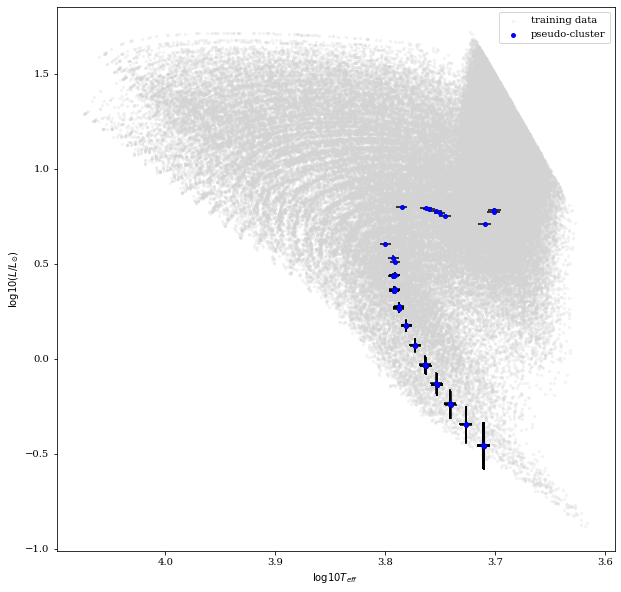

In [7]:
#showing cluster's location in HR
df = pd.read_csv('grid2_early.csv')
points = df[:100000]
HBMplot.plotClusterLocation(points, cluster_df, 'pseudo-cluster')

## HBM!!!

In [4]:
prior_mids = [3.6, 0, 0.28]
prior_widths = [2, 0.4, 0.04]
max_mass = 1.5

model = pm.Model()
with model:
    Age_mu = pm.Deterministic('mean_age',pm.Beta('a',1.1,1.1)*prior_widths[0]+prior_mids[0]-0.5*prior_widths[0])
    Age_sigma = pm.Lognormal('spread_age',T.log(0.15),0.4)
    feh_mu = pm.Deterministic('mean_feh',pm.Beta('e',1.1,1.1)*prior_widths[1]+prior_mids[1]-0.5*prior_widths[1])
    Y_mu = pm.Deterministic('mean_Y',pm.Beta('f',1.1,1.1)*prior_widths[2]+prior_mids[2]-0.5*prior_widths[2])
    MLT_mu = pm.Deterministic('mean_MLT',pm.Beta('g',1.1,1.1)*0.6+1.7)
    
    M = pm.Deterministic('mass', pm.Beta('d',1.1,1.1,shape=N)*(max_mass-0.8)+0.8)
    Age = pm.Deterministic('age',pm.Normal('age_normal', 0, 1, shape=N)*Age_sigma+Age_mu)
    feh = pm.Deterministic('feh',T.ones(N)*feh_mu)
    Y = pm.Deterministic('Y',T.ones(N)*Y_mu)
    MLT = pm.Deterministic('MLT',T.ones(N)*MLT_mu)
    
    obs = pm.Deterministic('obs',m1.manualPredict(T.log10([M, Age, 10**feh, Y, MLT])))
    
    true_Teff = pm.Deterministic('true_Teff', 10**obs[1,:]*5000)
    true_L = pm.Deterministic('true_L', (10**obs[0,:])**2*(true_Teff/5776.02970722)**4)
    true_delnu = pm.Deterministic('true_delnu', 10**obs[2,:])
    
    obs_L = pm.Normal('obs_L',true_L,sigma=0.1, observed=cluster_df['cal_lum'])
    obs_Teff = pm.Normal('obs_Teff',true_Teff,sigma=70, observed=cluster_df['Teff'])
    obs_delnu = pm.Normal('obs_delnu',true_delnu,sigma=0.1, observed=cluster_df['delnu'])

In [5]:
#loading in track and print summary stats
trace = pm.load_trace(directory='pymc3_traces/NNcluster12', model=model)
summary = pm.summary(trace, var_names=['mean_age','spread_age','mean_feh','mean_Y','mean_MLT'])
summary

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_age,3.219,0.053,3.120,3.313,0.018,0.013,8.0,8.0,8.0,53.0,1.43
spread_age,0.086,0.028,0.043,0.138,0.009,0.006,10.0,10.0,11.0,70.0,1.32
mean_feh,0.152,0.028,0.128,0.200,0.014,0.010,4.0,4.0,6.0,29.0,1.86
mean_Y,0.298,0.001,0.296,0.300,0.000,0.000,14.0,14.0,13.0,197.0,1.26
mean_MLT,1.996,0.033,1.957,2.062,0.016,0.012,4.0,4.0,6.0,57.0,1.79


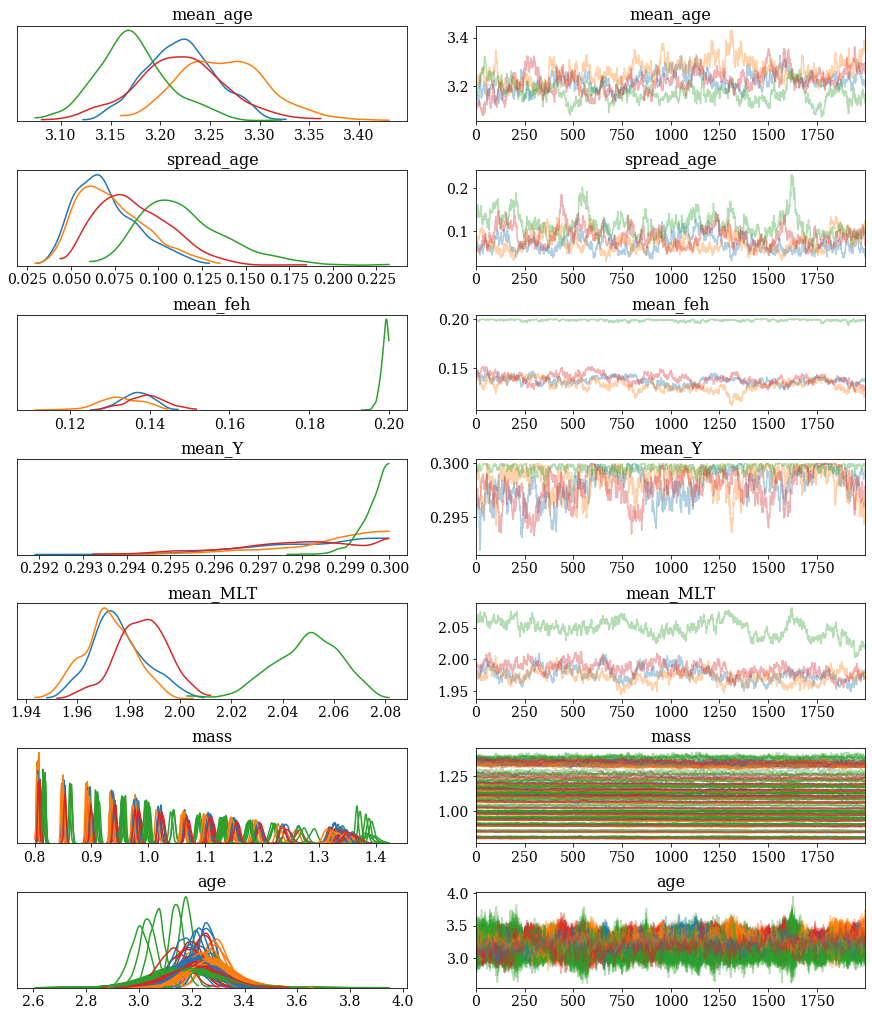

In [11]:
#trace plot
pm.plots.traceplot(trace,var_names=['mean_age','spread_age','mean_feh','mean_Y','mean_MLT','mass','age'],compact=True)
plt.show()

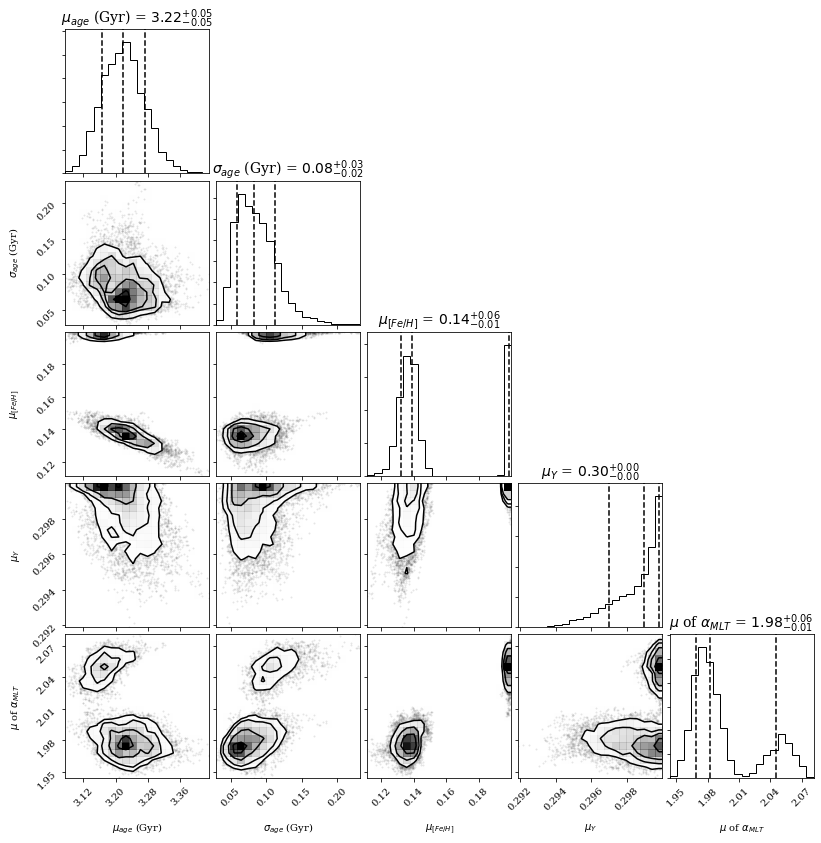

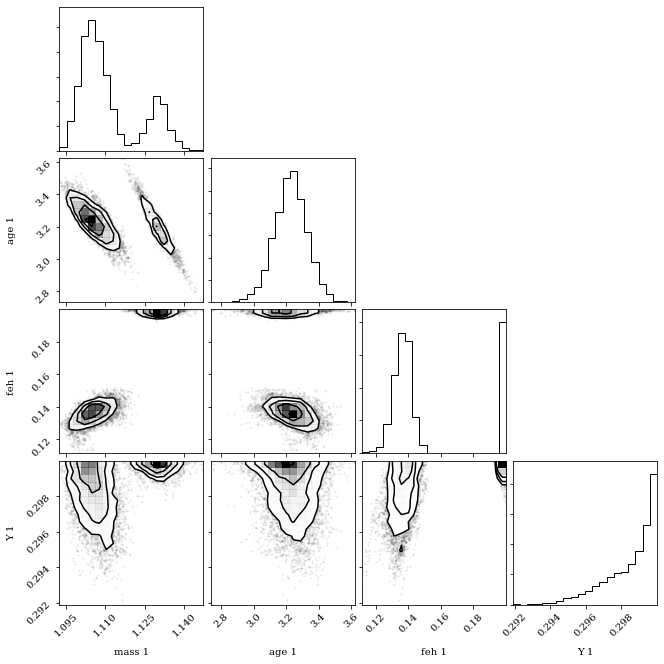

In [13]:
#corner plots
corner.corner(np.array([trace['mean_age'],trace['spread_age'],trace['mean_feh'],trace['mean_Y'],trace['mean_MLT']]).T,
              labels=[r'$\mu_{age}$ (Gyr)',r'$\sigma_{age}$ (Gyr)',r'$\mu_{[Fe/H]}$',
                      r'$\mu_{Y}$',r'$\mu$ of $\alpha_{MLT}$'],
             quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 14})
plt.show()

corner_array=[]
labels=[]
for i,star in cluster_df.iterrows():
    corner_array.append(trace['mass'].T[i])
    corner_array.append(trace['age'].T[i])
    corner_array.append(trace['feh'].T[i])
    corner_array.append(trace['Y'].T[i])
    labels.append('mass '+str(i+1))
    labels.append('age '+str(i+1))
    labels.append('feh '+str(i+1))
    labels.append('Y '+str(i+1))
    if i==0:
        break

corner.corner(np.array(corner_array).T,labels=labels)
plt.show()

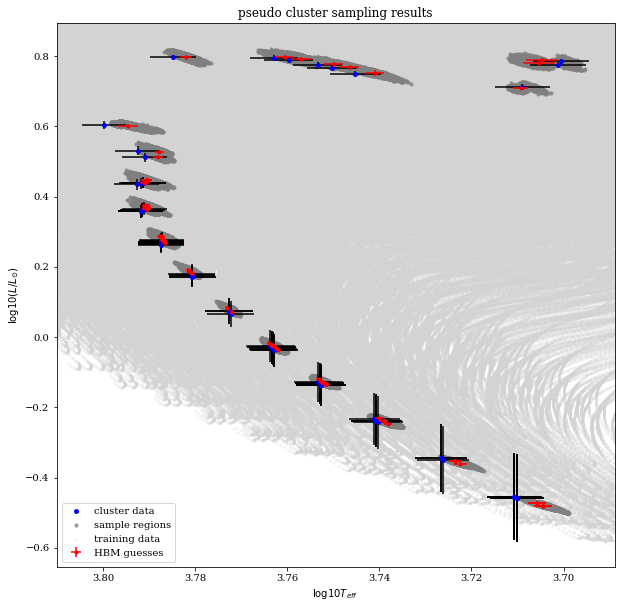

In [14]:
HBMplot.plotSample(trace, df, cluster_df, 'pseudo cluster sampling results', zoom_in=True)

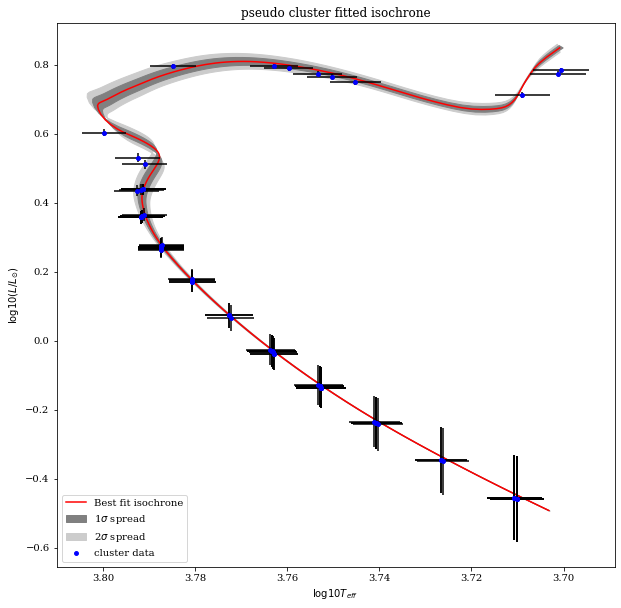

In [6]:
HBMplot.fittedIso(trace, m1.model, cluster_df, 'pseudo cluster fitted isochrone', cluster_type='pseudo')

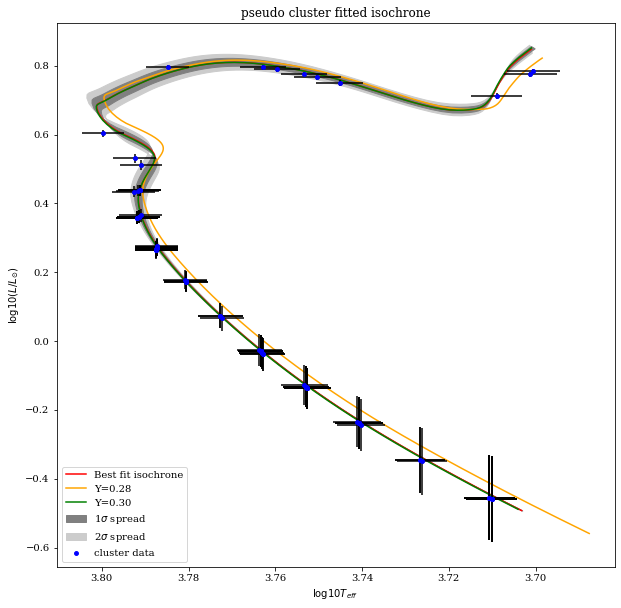

In [20]:
def plotIsochrone(model, ax, max_mass, age, feh, Y, MLT, label, N=1000, colour='red'):
    Tage = np.ones(N)*age
    Tmass = np.linspace(0.8,max_mass,N)
    Tfeh = np.ones(N)*feh
    TY = np.ones(N)*Y
    TMLT = np.ones(N)*MLT
    [TL, TTeff, Tdelnu] = HBMplot.predict(model, [Tmass, Tage, Tfeh, TY, TMLT])
    value = 10*np.log10(TTeff)-np.log10(TL)-35.5
    for i,v in enumerate(value):
        if v<0.65:
            TTeff = TTeff[:i]
            TL = TL[:i]
            break
    ax.plot(np.log10(TTeff),np.log10(TL),colour,zorder=1, label=label)

ma = np.percentile(trace['mean_age'],50)
sa = np.percentile(trace['spread_age'],50)
mf = np.percentile(trace['mean_feh'],50)
my = np.percentile(trace['mean_Y'],50)
mmlt = np.percentile(trace['mean_MLT'],50)

fig, ax=plt.subplots(1,1,figsize=[10,10])
HBMplot.clusterPlot(cluster_df, ax, 'blue', 'cluster data')
HBMplot.plotIsochrone(m1.model, ax, 1.5, ma, mf, my, mmlt)
plotIsochrone(m1.model, ax, 1.5, ma, mf, 0.28, mmlt, 'Y=0.28', colour='orange')
plotIsochrone(m1.model, ax, 1.5, ma, mf, 0.30, mmlt, 'Y=0.30', colour='green')
#plotIsochrone(m1.model, ax, 1.5, 3.6, 0, 0.28, 1.9, 'true isochrone', colour='cyan')
lims = [ax.get_xlim(),ax.get_ylim()]
one_sigma = [[ma-sa, ma+sa],mf,my]
two_sigma = [[ma-2*sa, ma+2*sa],mf,my]
HBMplot.sigmaPlot(m1.model, ax, one_sigma, mmlt, ([0.5,0.5,0.5]), 0, 5, r'1$\sigma$ spread')
HBMplot.sigmaPlot(m1.model, ax, two_sigma, mmlt, ([0.8,0.8,0.8]), -1, 9, r'2$\sigma$ spread')
ax.set_xlim(lims[0][::-1])
ax.set_ylim(lims[1])
ax.set_xlabel(r'$\log10 T_{eff}$')
ax.set_ylabel(r'$\log10(L/L_{\odot})$')
ax.legend()
ax.set_title('pseudo cluster fitted isochrone')
plt.show()